## Kepler GL maps in jupyter

In [1]:
import keplergl
import pandas as pd
import numpy as np
import geopandas

kp_data = {'tul': 'C:/Users/NECSOFT/Documents/Repositories/LRP/Data/upz.geojson',
            'home': 'E:/Main User/Documents/Repositories/VRP/Data/upz.geojson'}
hardware_stores_path = {'tul':'C:/Users/NECSOFT/Documents/Repositories/LRP/Data/client_hardwares.csv',
                        'home':'E:/Main User/Documents/Repositories/VRP/Data/client_hardwares.csv'}
warehouses_path = {'tul':'C:/Users/NECSOFT/Documents/Repositories/LRP/Data/potential_warehouses.csv',
                    'home':'E:/Main User/Documents/Repositories/VRP/Data/potential_warehouses.csv'}

location = 'tul'
df_hs = pd.read_csv(hardware_stores_path[location]) 

df_w = pd.read_csv(warehouses_path[location])
print(df_hs.head())
bogota_map = keplergl.KeplerGl(height=700)
#data={'clientes': df_hs})
upz_file = open(kp_data[location])
upz_bogota = geopandas.read_file(upz_file)

bogota_map.add_data(data=upz_bogota, name="UPZ Bogotá")
bogota_map.add_data(data=df_w, name="Bodegas")
bogota_map.add_data(data=df_hs, name="Clientes")
bogota_map


   LATITUDE  LONGITUDE    ID  TOTAL_DELIVERIES  KG_DEMAND
0  4.685108 -74.100933   683                41         57
1  4.671309 -74.105405   787               120        249
2 -2.891841 -69.741923   296               183        213
3  4.582506 -74.115791  6158                27        817
4  5.614484 -73.821126   810                70        252
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'UPZ Bogotá': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

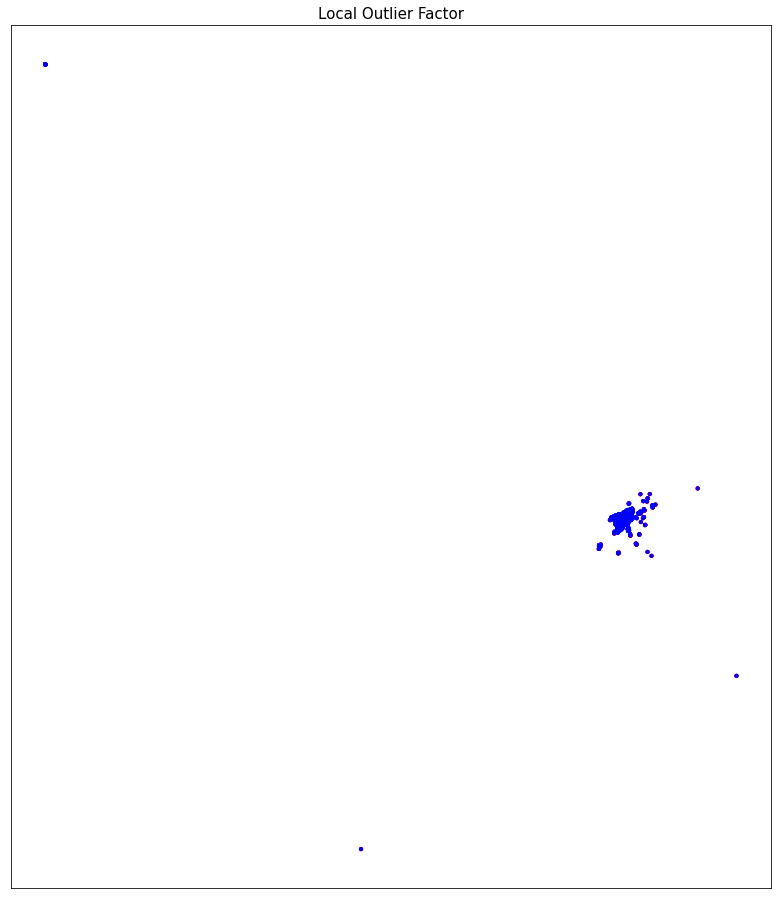

In [4]:
# Outlier detection algorithm
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

dataset = []
dict_hs = df_hs.to_dict(orient='index')
dataset.append(np.array([[dict_hs[j]['LATITUDE'], 
                        dict_hs[j]['LONGITUDE'],
                        dict_hs[j]['ID']]
                        for j in dict_hs]))

anomaly_algorithms = [
    ("One-Class SVM 0.1", svm.OneClassSVM(kernel="rbf",gamma=0.1)),
    ("Robust covariance", EllipticEnvelope()),
    ("Isolation Forest", IsolationForest(random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35))
    ]

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                hspace=.01)
plot_num = 1

results, result_dict = {},{}
for i_dataset, X in enumerate(dataset):
    for name, algorithm in anomaly_algorithms:
        
        if i_dataset == 0:
            plt.title(name, size=15)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        
        colors = np.array(['red', 'blue']) #outliers, inliers
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
        
        results = {'inliers':sum([1 for index in y_pred if index == 1]),
                    'outliers':sum([1 for index in y_pred if index == -1]),
                    'results_df':pd.DataFrame(result_dict)}
        
        result_dict[name] = {'lat': X[:, 0],
                            'long':X[:, 1],
                            'id': X[:, 2],
                            'y_pred': y_pred,
                            'outlier_rate': round(results['outliers']/(results['outliers']+results['inliers']), 2),
                            'inlier_rate': round(results['inliers']/(results['outliers']+results['inliers']), 2),
                            'model': name
                            }

        #plt.show()


### ahora lo que necesitamos es observar en el mapa la muestra resultante con la cual haremos todos los analisis

In [5]:
# export data for further analysis
import json

client_data = {}
for key in result_dict.keys():
    model_df = pd.DataFrame(result_dict[key])
    client_df = model_df.loc[model_df['y_pred'] == 1]
    client_df = client_df.filter(items=['lat', 'long', 'id'])
    client_data[key] = client_df
    
# visualizar el nuevo mapa para verificar resultados obtenidos
outlier_map = keplergl.KeplerGl(height=700, data=client_data)
outlier_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'One-Class SVM 0.1':           lat       long       id
2   -2.891841 -69.741923    296.0
3    4…

In [6]:
# export data so we can do matrixes
import json

model_df = pd.DataFrame(result_dict[ "Isolation Forest"])
client_df = model_df.loc[model_df['y_pred'] == 1]
client_df = client_df.filter(items=['lat', 'long','id'])
client_df['point_type'] = ['client' for i in range(len(client_df))]

warehouses_df = df_w.filter(items=['LATITUDE', 'LONGITUDE'])
warehouses_df['POINT_TYPE'] = ['warehouse' for i in range(len(warehouses_df))]
warehouses_df['ID'] = [i for i in range(len(warehouses_df))]
warehouses_df.columns = ['lat', 'long', 'point_type', 'id']

data_dict = pd.concat([warehouses_df, client_df])

# send to json format
data_dict = data_dict.to_dict("records")
with open("Data/problem_set.json", "w+") as f:
    json.dump(data_dict, f)


In [34]:
print(warehouses_df)

         lat       long point_type
0   4.695547 -74.179464  warehouse
1   4.639974 -74.115102  warehouse
2   4.624162 -74.088473  warehouse
3   4.624579 -74.093208  warehouse
4   4.621671 -74.093444  warehouse
5   4.744053 -74.037572  warehouse
6   4.678669 -74.087210  warehouse
7   4.742840 -74.043839  warehouse
8   4.739659 -74.036666  warehouse
9   4.744037 -74.038729  warehouse
10  4.748230 -74.044135  warehouse
11  4.693394 -74.077673  warehouse
12  4.667625 -74.072527  warehouse
13  4.686995 -74.088007  warehouse
14  4.676962 -74.114360  warehouse
15  4.743033 -74.045203  warehouse
16  4.764400 -74.028227  warehouse
17  4.662928 -74.068255  warehouse
18  4.764406 -74.030120  warehouse
19  4.682957 -74.129021  warehouse
20  4.737055 -74.025836  warehouse
21  4.730675 -74.024984  warehouse
22  4.629594 -74.119054  warehouse
23  4.677934 -74.162860  warehouse
24  4.642311 -74.119973  warehouse
25  4.629486 -74.109202  warehouse
26  4.697149 -74.097457  warehouse
27  4.606654 -74.099